In [1]:
# ref : https://signate.jp/competitions/169/discussions/convolutional-lstm-1

In [2]:
# !python -m pip install basemap

In [3]:
import gzip
import os
import shutil

%matplotlib inline
import warnings
from datetime import datetime as dt
from datetime import timedelta

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.basemap import Basemap

warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

In [4]:
# 学習向け
import argparse
import os
import random
import sys
import time

import albumentations as A
import numpy as np
import torch
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from torch import nn
from torch.autograd import Variable
from torch.nn import init
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm.autonotebook import tqdm as tqdm
from PIL import Image

/home/jovyan/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
DATAROOT = "../../data/distributed/"

# 画像ロードをテスト

../../data/distributed/train/sat/2017-08-01/2017-08-01-00-00.fv.png
image shape :  (672, 512)
data type :  uint8


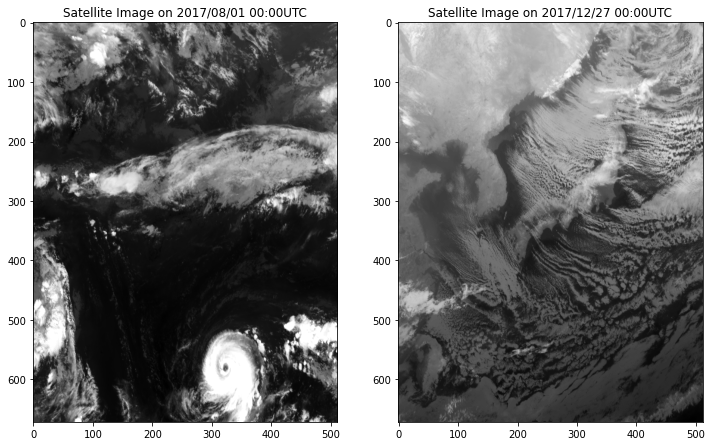

In [6]:
file1 = f"{DATAROOT}train/sat/2017-08-01/2017-08-01-00-00.fv.png"
file2 = f"{DATAROOT}train/sat/2017-12-27/2017-12-27-00-00.fv.png"
print(file1)
img1 = cv2.imread(file1, 0)
img2 = cv2.imread(file2, 0)

print("image shape : ", img1.shape)
print("data type : ", img1.dtype)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(img1, cmap="gray")
axes[0].set_title("Satellite Image on 2017/08/01 00:00UTC")
axes[1].imshow(img2, cmap="gray")
axes[1].set_title("Satellite Image on 2017/12/27 00:00UTC")
plt.show()

# 出力フォルダ作成＆ロガー作成

In [7]:
from datetime import datetime, timezone, timedelta
import os
tz_jst = timezone(timedelta(hours=9))
train_start_time = datetime.now(tz=tz_jst).strftime('%Y%m%d_%H%M')
out_root = "./output/"
out_root = out_root + train_start_time +  "/"

os.makedirs(out_root, exist_ok=True)

In [8]:
import logging

def setLogger(output_path):
    logging_outfile = output_path + "/logger.log"
    logging.basicConfig(
        level=logging.DEBUG,
        format="[%(asctime)s][%(name)s][%(funcName)s][%(levelname)s] %(message)s",
        filename=str(logging_outfile),
        filemode="w"
    )
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)

    ## sets up stream handler
    shandler = logging.StreamHandler()
    shandler.setLevel(logging.INFO)

    ## sets up formatter
    formatter = logging.Formatter("[%(asctime)s][%(name)s][%(funcName)s][%(levelname)s] %(message)s")
    shandler.setFormatter(formatter)

    ## adds handlers to logger
    logger.addHandler(shandler)
    return logger

logger = setLogger(out_root)

# CFG設定

In [9]:
class CFG:
    def __init__(self):

        self.debug = False
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.prev = 24 
        self.post = 24
        self.T_max = 4
        self.seed = 42
        self.num_layers = 3
        self.batch_size = 8
        self.test_batch = 1
        self.n_channels = 1
        self.lstm_dim = 128
        self.num_workers = 4
        self.image_size = (168, 128)
        self.lr = 1e-3
        self.min_lr = 1e-4
        self.weight_decay = 5e-5
        self.epochs = 50


CONFIG = CFG()

In [10]:
def seed_everything(seed: int == 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(CONFIG.seed)

# 2 : convolutional-LSTMの実装サンプルです。
* 参考にしたページ①：https://signate.jp/competitions/169/discussions/convolutional-lstm-1
* 参考にしたページ②：https://qiita.com/satolab/items/bac43905f3427910d057
* 参考にしたページ③：https://comp.probspace.com/competitions/religious_art/discussions/skywalker-Post1a375b68565d3d022e6a


## 2-1: データローダーの作成

In [11]:
# 衛星画像読み込みクラス
# all_days : スタートの日付を含む、取り扱う日数
# year, month, day : スタートの日付
# prev : 実況レンジ衛星画像コマ数
# post : 予測レンジ衛星画像コマ数
# step : 何日ごとにデータセットを作るか
# デフォルトでは2日分で1つのデータセットにしているので、all_daysは364でyear1年分のデータセットになる
# resize : 画像をリサイズ（縮小）する場合、縦横を何分の１にするか


class TrainDataset:
    def __init__(
        self,
        all_days=364,
        year=2017,
        month=1,
        day=1,
        hour=0,
        prev=24,
        post=24,
        step=1,
        transform=None,
    ):
        self.all_days = all_days
        self.year = year
        self.month = month
        self.day = day
        self.hour = hour
        self.prev = prev
        self.post = post
        self.step = step
        self.init_date = dt(year, month, day, hour, 0, 0)
        self.transform = transform

    def __len__(self):
        return self.all_days

    def __getitem__(self, i):
        # i はnumpy.int64型で、このままだとエラーになるのでint型ｙｙにする
        start_date = self.init_date + timedelta(days=self.step * int(i))

        img_list = []
        for j in range(self.prev + self.post):
            date = start_date + timedelta(hours=j)
            file = (
                DATAROOT
                + "train/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".format(
                    year=date.year, month=date.month, day=date.day, hour=date.hour
                )
            )

            # グレースケールで画像を読み込む
            if os.path.exists(file):
                tmp = cv2.imread(file, 0)
                tmp = self.transform(image=tmp)["image"]
            else:
                # 欠損データの扱いは別で検討。
                tmp = np.zeros((1, 168, 128))

            img_list.append(tmp)

        image = np.stack(img_list)
        # image = image.reshape( *image.shape, 1 )

        # 学習用xと評価用tを正規化して返す
        x_images = (image[: self.prev] / 255).astype(np.float32)
        y_images = (image[self.prev :] / 255).astype(np.float32)

        return {
            "image": torch.tensor(x_images, dtype=torch.float),
            "target": torch.tensor(y_images, dtype=torch.float),
        }

In [12]:
# Albumentationsで前処理を作成。
def get_transforms(*, data):

    if data == "train":
        return A.Compose(
            [
                A.Resize(CONFIG.image_size[0], CONFIG.image_size[1]),
                # A.VerticalFlip(p=0.5),
                # A.HorizontalFlip(p=0.5),
                # A.Rotate(p=0.3),
                # A.ToSepia(p=0.3),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return A.Compose(
            [A.Resize(CONFIG.image_size[0], CONFIG.image_size[1]), ToTensorV2()]
        )

In [13]:
# datasetクラスのテスト
train_dataset = TrainDataset(
    year=2017,
    month=1,
    hour=1,
    step=1,
    prev=CONFIG.prev,
    post=CONFIG.post,
    transform=get_transforms(data="train"),
)

In [14]:
# データ生成関数のテスト。時系列認識系は、TCHWの並び順になるらしい。
print(train_dataset[0]["image"].shape)
print(train_dataset[0]["target"].shape)

torch.Size([24, 1, 168, 128])
torch.Size([24, 1, 168, 128])


In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    num_workers=CONFIG.num_workers,
    pin_memory=True,
    shuffle=True,
)

In [16]:
# データローダーのテスト
for step, data in enumerate(train_loader):
    print(step)
    x_images = data["image"]
    y_images = data["target"]
    print(x_images.shape)
    print(y_images.shape)
    break

0
torch.Size([4, 24, 1, 168, 128])
torch.Size([4, 24, 1, 168, 128])


## 2-2 : モデル定義

In [17]:
# 参考にしたgithubのリンクから流用。Tips：LSTMは今や関数化されているので、定義しなくてもOK。

class FReLU(nn.Module):
    def __init__(self, in_c, k=3, s=1, p=1):
        super().__init__()
        self.f_cond = nn.Conv2d(
            in_c, in_c, kernel_size=k, stride=s, padding=p, groups=in_c
        )
        self.bn = nn.BatchNorm2d(in_c)

    def forward(self, x):
        tx = self.bn(self.f_cond(x))
        out = torch.max(x, tx)
        return out


class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------f
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.input_dim + self.hidden_dim,
            out_channels=4 * self.hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias,
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat(
            [input_tensor, h_cur], dim=1
        )  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (
            torch.zeros(
                batch_size,
                self.hidden_dim,
                height,
                width,
                device=self.conv.weight.device,
            ),
            torch.zeros(
                batch_size,
                self.hidden_dim,
                height,
                width,
                device=self.conv.weight.device,
            ),
        )


class SASTANGen(nn.Module):
    def __init__(self, CONFIG, ch=64, dropout=False):
        self.CONFIG = CONFIG

        super(SASTANGen, self).__init__()
        self.enc1 = self.conv_bn_relu(
            CONFIG.n_channels, ch, kernel_size=3, no_batch=True
        )  # 32x96x96
        self.enc2 = self.conv_bn_relu(
            ch, ch * 2, kernel_size=3, pool_kernel=2
        )  # 64x24x24
        self.enc3 = self.conv_bn_relu(
            ch * 2, ch * 4, kernel_size=3, pool_kernel=2
        )  # 128x12x12
        self.enc4 = self.conv_bn_relu(
            ch * 4, ch * 8, kernel_size=3, pool_kernel=2
        )  # 256x6x6

        self.dec1 = self.conv_bn_relu(
            ch * 8, ch * 4, kernel_size=3, pool_kernel=-2
        )  # 128x12x12
        self.dec2 = self.conv_bn_relu(
            ch * 4, ch * 2, kernel_size=3, pool_kernel=-2
        )  # 64x24x24
        self.dec3 = self.conv_bn_relu(
            ch * 2, ch, kernel_size=3, pool_kernel=-2
        )  # 32x96x96
        self.dec4 = self.conv_bn_relu(
            ch, ch, kernel_size=3
        )  # , pool_kernel=-2)  # 32x96x96

        self.dec5 = nn.Sequential(
            nn.Conv2d(ch, CONFIG.post * CONFIG.n_channels, kernel_size=3, padding=1),
            # nn.Tanh()
            nn.Sigmoid(),
        )

        self.encoder_1_convlstm = ConvLSTMCell(
            input_dim=256 * 2, hidden_dim=CONFIG.lstm_dim, kernel_size=(3, 3), bias=True
        )

        self.encoder_2_convlstm = ConvLSTMCell(
            input_dim=CONFIG.lstm_dim,
            hidden_dim=CONFIG.lstm_dim,
            kernel_size=(3, 3),
            bias=True,
        )

        self.encoder_3_convlstm = ConvLSTMCell(
            input_dim=CONFIG.lstm_dim,  # nf + 1
            hidden_dim=CONFIG.lstm_dim,
            kernel_size=(3, 3),
            bias=True,
        )

        self.decoder_convlstm = ConvLSTMCell(
            input_dim=CONFIG.lstm_dim, hidden_dim=256 * 2, kernel_size=(3, 3), bias=True
        )

        self.init_weights()

    def init_weights(self):
        self.param_count = 0
        for module in self.modules():
            if (
                isinstance(module, nn.Conv2d)
                or isinstance(module, nn.ConvTranspose2d)
                or isinstance(module, nn.Linear)
                or isinstance(module, nn.Embedding)
            ):
                init.orthogonal_(module.weight)

    def conv_bn_relu(
        self,
        in_ch,
        out_ch,
        kernel_size=3,
        pool_kernel=None,
        no_batch=False,
        drop_out=False,
    ):
        layers = []
        if pool_kernel is not None:
            if pool_kernel > 0:
                layers.append(nn.AvgPool2d(pool_kernel))
            elif pool_kernel < 0:
                layers.append(nn.UpsamplingNearest2d(scale_factor=-pool_kernel))
        layers.append(
            nn.Conv2d(in_ch, out_ch, kernel_size, padding=(kernel_size - 1) // 2)
        )

        if no_batch:
            layers.append(FReLU(out_ch))
        else:
            layers.append(nn.BatchNorm2d(out_ch))
            layers.append(FReLU(out_ch))
            if drop_out:
                nn.Dropout(0.5)

        return nn.Sequential(*layers)

    def convlstm_layer(self, x, seq_len, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4):

        for t in range(seq_len):

            h_t, c_t = self.encoder_1_convlstm(
                input_tensor=x[:, t, :, :, :], cur_state=[h_t, c_t]  # [:, t, :, :],
            )  # we could concat to provide skip conn here
            h_t2, c_t2 = self.encoder_2_convlstm(
                input_tensor=h_t, cur_state=[h_t2, c_t2]
            )  # we could concat to provide skip conn here
            h_t3, c_t3 = self.encoder_3_convlstm(
                input_tensor=h_t2, cur_state=[h_t3, c_t3]
            )  # we could concat to provide skip conn here
        # encoder_vector
        encoder_vector = h_t2
        # decoder
        # for t in range(future_step):
        h_t4, c_t4 = self.decoder_convlstm(
            input_tensor=h_t3, cur_state=[h_t4, c_t4]
        )  # we could concat to provide skip conn here

        return h_t4

    def forward(self, x):
        b, seq_len, _, h_in, w_in = x.size()
        h = int(2 * h_in / (16))  # +2
        w = int(2 * w_in / (16))  # +2

        # initialize hidden states
        h_t, c_t = self.encoder_1_convlstm.init_hidden(batch_size=b, image_size=(h, w))
        h_t2, c_t2 = self.encoder_2_convlstm.init_hidden(
            batch_size=b, image_size=(h, w)
        )
        h_t3, c_t3 = self.encoder_3_convlstm.init_hidden(
            batch_size=b, image_size=(h, w)
        )
        h_t4, c_t4 = self.decoder_convlstm.init_hidden(batch_size=b, image_size=(h, w))

        # CNN
        x_reshape = x.reshape(
            b * self.CONFIG.prev,
            self.CONFIG.n_channels,
            self.CONFIG.image_size[0],
            self.CONFIG.image_size[1],
        )
        x1 = self.enc1(x_reshape)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)

        # LSTM
        feature_enc = x4.reshape(b, self.CONFIG.prev, 256 * 2, h, w)
        feature_lstm = self.convlstm_layer(
            feature_enc, self.CONFIG.prev, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4
        )
        
        # cnn
        out = self.dec1(feature_lstm)
        out = self.dec2(out)
        out = self.dec3(out)
        out = self.dec4(out)
        xhat = self.dec5(out)
        return xhat.reshape(b, self.CONFIG.post, 1, h_in, w_in)

In [18]:
model = SASTANGen(CONFIG)

In [19]:
# データローダーのテスト。NTCHWになります。
for step, data in enumerate(train_loader):
    print(step)
    x_images = data["image"]
    y_images = data["target"]
    preds = model(x_images)
    print(x_images.shape)
    print(preds.shape)
    break

0
torch.Size([4, 24, 1, 168, 128])
torch.Size([4, 24, 1, 168, 128])


# 2-3 学習用Helper function

In [20]:
def train_func(model, optimizer, scheduler, loss_fn, dataloader, device):

    model.train()
    final_loss = 0

    for step, data in enumerate(tqdm(dataloader)):

        s_t = time.time()
        optimizer.zero_grad()

        image = data["image"].to(device)
        label = data["target"].to(device)
        batch_size = label.size(0)

        preds = model(image)

        loss = loss_fn(preds, label)

        e_t = time.time()
        e_t = e_t - s_t

        loss.backward()
        optimizer.step()
        scheduler.step()

        final_loss += loss.item()

    final_loss /= len(dataloader)

    return final_loss

In [21]:
def valid_func(model, loss_fn, dataloader, device):

    model.eval()

    final_loss = 0
    valid_preds = []
    valid_targets = []
    
    for step, data in enumerate(tqdm(dataloader)):

        s_t = time.time()
        image = data["image"].to(device)
        label = data["target"].to(device)

        preds = model(image)

        loss = loss_fn(preds, label)
        e_t = time.time()
        e_t = e_t - s_t

        valid_preds.append(preds.detach().cpu().numpy())
        valid_targets.append(label.detach().cpu().numpy())
        final_loss += loss.item()

    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    valid_targets = np.concatenate(valid_targets)
    
    return final_loss, valid_preds, valid_targets

In [22]:
def test_func(model, dataloader, device):

    model.eval()

    final_loss = 0
    test_preds = []

    for step, data in enumerate(tqdm(dataloader)):

        s_t = time.time()
        image = data["image"].to(device)

        preds = model(image)

        e_t = time.time()
        e_t = e_t - s_t

        test_preds.append(preds.detach().cpu().numpy())

    test_preds = np.concatenate(test_preds)

    return test_preds

# 2-4 : main 

In [23]:
model = SASTANGen(CONFIG)
model.to(CONFIG.device)

# このあたりの学習設定は適当に決めています。
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=CONFIG.lr, weight_decay=CONFIG.weight_decay
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=CONFIG.T_max, eta_min=CONFIG.min_lr, last_epoch=-1
)

# データローダの作成。
train_dataset = TrainDataset(
    year=2016,
    month=1,
    hour=1,
    step=1,
    prev=CONFIG.prev,
    post=CONFIG.post,
    transform=get_transforms(data="train"),
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=CONFIG.batch_size,
    num_workers=CONFIG.num_workers,
    pin_memory=True,
    shuffle=True,
)
# has all image shape,[data,label]
valid_dataset = TrainDataset(
    year=2017,
    month=7,
    all_days=180,
    prev=CONFIG.prev,
    post=CONFIG.post,
    transform=get_transforms(data="test"),
)
valid_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=CONFIG.batch_size,
    num_workers=CONFIG.num_workers,
    pin_memory=True,
    shuffle=True,
)

In [24]:
# 更新用変数を作成。ロスなので∞からスタート。Accuracyとかだったら0にしておく。
best_score = np.inf

for epoch in range(CONFIG.epochs):

    start_time = time.time()
    
    #学習関数
    train_loss = train_func(
        model, optimizer, scheduler, loss_fn, train_loader, CONFIG.device
    )
    #Valid関数
    valid_loss, valid_preds, valid_targets = valid_func(
        model, loss_fn, valid_loader, CONFIG.device
    )

    # 今回の最適化スコアはロス値としました。必要に応じてAccuracyとかを使うのがいいかも。
    score = valid_loss
    end_time = time.time()
    logger.info(
        f"EPOCH:{epoch+1:02d} | train_loss:{train_loss:.6f} | valid_loss:{valid_loss:.6f} | time:{end_time-start_time:.1f}s "
    )
    
    # validの結果を保存してみる。これはしなくてもOK。私が見たいから追加
    os.makedirs(f'{out_root}/valid_results/epoch_{epoch:03}/', exist_ok=True)
    for batch in range(valid_preds.shape[0]):
        images = []
        for idx in range(valid_preds.shape[1]):
            im_h = (cv2.hconcat([valid_preds[batch][idx][0], valid_targets[batch][idx][0]])*255).astype(np.uint8)
            pil_image = Image.fromarray(np.stack([im_h, im_h,im_h],axis=-1))
            images.append(pil_image)
        images[0].save(f'{out_root}/valid_results/epoch_{epoch:03}/batch_{batch:03}.gif', save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)
        
    #ロス更新されたら保存。
    if score < best_score:
        best_score = score

        MODEL_PATH = f"./{out_root}topic_001_baseline_best.pth"
        torch.save(model.state_dict(), MODEL_PATH)
        logger.info(f"update best : {epoch}")
    else:
        continue

del train_dataset, valid_dataset, train_loader, valid_loader, valid_preds, valid_targets

100%|██████████| 46/46 [00:21<00:00,  2.13it/s]
[2022-10-25 15:48:10,892][__main__][<module>][INFO] EPOCH:01 | train_loss:0.038443 | valid_loss:0.043629 | time:44.0s 
[2022-10-25 15:48:33,630][__main__][<module>][INFO] update best : 0
100%|██████████| 46/46 [00:21<00:00,  2.15it/s]
[2022-10-25 15:49:17,660][__main__][<module>][INFO] EPOCH:02 | train_loss:0.029083 | valid_loss:0.028602 | time:44.0s 
[2022-10-25 15:49:40,881][__main__][<module>][INFO] update best : 1
100%|██████████| 46/46 [00:21<00:00,  2.14it/s]
[2022-10-25 15:50:24,883][__main__][<module>][INFO] EPOCH:03 | train_loss:0.027699 | valid_loss:0.027434 | time:44.0s 
[2022-10-25 15:50:47,886][__main__][<module>][INFO] update best : 2
100%|██████████| 46/46 [00:21<00:00,  2.13it/s]
[2022-10-25 15:51:31,851][__main__][<module>][INFO] EPOCH:04 | train_loss:0.027750 | valid_loss:0.028905 | time:44.0s 
100%|██████████| 46/46 [00:21<00:00,  2.14it/s]
[2022-10-25 15:52:38,592][__main__][<module>][INFO] EPOCH:05 | train_loss:0.0269

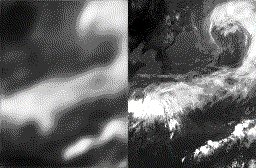

In [27]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path

#最後に保存したGIFを表示
gifPath = Path(f'{out_root}/valid_results/epoch_{epoch:03}/batch_{batch:03}.gif')

with open(gifPath,'rb') as f:
  display.Image(data=f.read(), format='png')